<a href="https://colab.research.google.com/github/HangKunLee/DeepLearning/blob/master/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)

2.15.0


#***1.Importing the CIFAR10 set***












In [3]:
# Load in the data
cifar10 = tf.keras.datasets.cifar10

# Distribute it to train and test set
(train_imgs, train_labels), (test_imgs, test_labels) = cifar10.load_data()


print(train_imgs.shape, train_labels.shape, test_imgs.shape, test_labels.shape)

170498071/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


#***2.Visualizing the dataset***



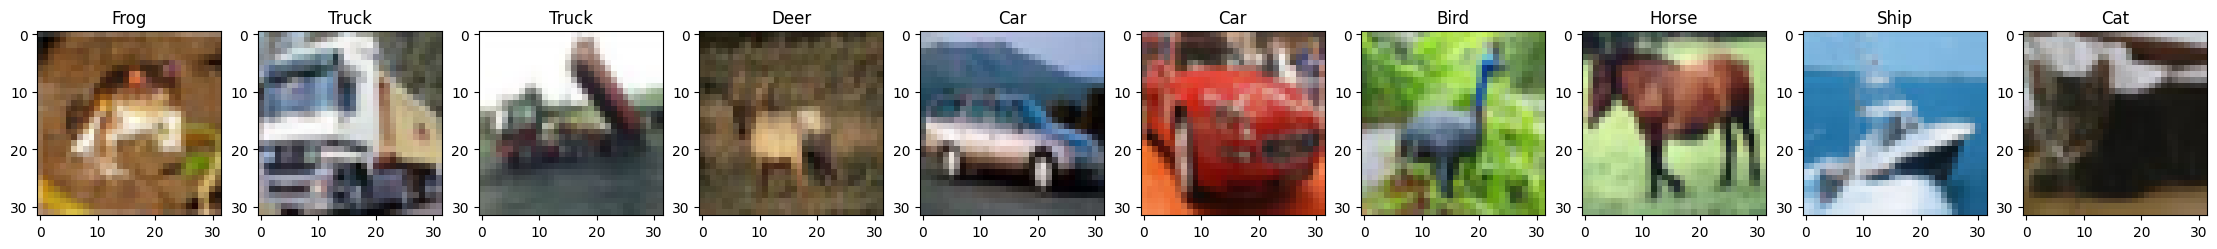

In [4]:

class_names = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
fig, axes = plt.subplots(1,10,figsize=(28,28))

for i in range(10):
    axes[i].imshow(train_imgs[i], cmap='binary')
    axes[i].set_title(class_names[train_labels[i][0]])


# ***3.Preparing the data***

In [5]:
# Reduce pixel values
train_imgs, test_imgs = train_imgs / 255.0, test_imgs / 255.0
img_rows, img_cols , channels= 32,32,3
# Flatten the label values
train_labels, test_labels = train_labels.flatten(), test_labels.flatten()
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    #zoom_range=0.3
    )
datagen.fit(train_imgs)

train_imgs = train_imgs.reshape(train_imgs.shape[0], img_rows, img_cols, channels)
test_imgs = test_imgs.reshape(test_imgs.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, 1)
print('train_imgs shape:', train_imgs.shape)
print(train_imgs.shape[0], 'train samples')
print(test_imgs.shape[0], 'test samples')

# Convert integers to float; Normalize and center the mean
train_imgs=train_imgs.astype("float32")
test_imgs=test_imgs.astype("float32")
mean=np.mean(train_imgs)
std=np.std(train_imgs)
test_imgs=(test_imgs-mean)/std
train_imgs=(train_imgs-mean)/std
# labels
num_classes=10

train_imgs shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


# ***4.CNN training and prediction***

##**4.1 CNN Model Structure**


In [6]:
def create_model():

 # Input layer
 i = Input(shape=train_imgs[0].shape)
 x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
 x = BatchNormalization()(x)
 x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
 x = BatchNormalization()(x)
 x = MaxPooling2D((2, 2))(x)

 x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
 x = BatchNormalization()(x)
 x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
 x = BatchNormalization()(x)
 x = MaxPooling2D((2, 2))(x)

 x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
 x = BatchNormalization()(x)
 x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
 x = BatchNormalization()(x)
 x = MaxPooling2D((2, 2))(x)

 x = Flatten()(x)
 x = Dropout(0.5)(x) #Neuron dropout to stop overfitting

# Hidden layer
 x = Dense(1024, activation='relu')(x)
 x = Dropout(0.5)(x)

# Output layer
 x = Dense(10, activation='softmax')(x)

 model = Model(i, x)
 return model


In [24]:
model = create_model()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## **4.2 Model Summary**

In [25]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_26 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_27 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_27 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 16, 32)        0   

## **4.3 TPU Setup**

In [11]:
import os
import tensorflow as tf

try:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', resolver.master())
except ValueError:
  print('Not connected to a TPU runtime. Using CPU/GPU instead.')
  resolver = None # Explicitly set resolver to None if TPU not found


if resolver:
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.experimental.TPUStrategy(resolver)
    print("All devices: ", tf.config.list_logical_devices('TPU'))
else:
    # Code to run if TPU is not available (e.g., using CPU or GPU)
    strategy = tf.distribute.get_strategy() # Default strategy for CPU/GPU
    print("All devices: ", tf.config.list_logical_devices())

Running on TPU  


All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


In [13]:
tf.keras.backend.clear_session()

resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)

tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.experimental.TPUStrategy(resolver)

KeyError: 'COLAB_TPU_ADDR'

### **4.4 TPU Compilation and Training**

In [14]:
with strategy.scope():
  model = create_model()
  model.compile(
      optimizer='Adam',
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'])

network = model.fit(
    train_imgs.astype(np.float32), train_labels.astype(np.float32),
    shuffle=True,
    epochs=50,
    steps_per_epoch=60,
    validation_data=(test_imgs.astype(np.float32), test_labels.astype(np.float32)),
    validation_freq=10
)

model.save_weights('./cifar10_weights.h5', overwrite=True)

Epoch 1/50
60/60 [==============================] - 13s 82ms/step - loss: 2.2565 - accuracy: 0.3474
Epoch 2/50
60/60 [==============================] - 1s 24ms/step - loss: 1.4166 - accuracy: 0.4850
Epoch 3/50
60/60 [==============================] - 1s 23ms/step - loss: 1.2384 - accuracy: 0.5512
Epoch 4/50
60/60 [==============================] - 1s 23ms/step - loss: 1.0734 - accuracy: 0.6169
Epoch 5/50
60/60 [==============================] - 1s 23ms/step - loss: 0.9405 - accuracy: 0.6643
Epoch 6/50
60/60 [==============================] - 1s 23ms/step - loss: 0.8582 - accuracy: 0.6943
Epoch 7/50
60/60 [==============================] - 1s 23ms/step - loss: 0.7774 - accuracy: 0.7224
Epoch 8/50
60/60 [==============================] - 1s 23ms/step - loss: 0.7167 - accuracy: 0.7465
Epoch 9/50
60/60 [==============================] - 1s 24ms/step - loss: 0.6649 - accuracy: 0.7655
Epoch 10/50
60/60 [==============================] - 7s 119ms/step - loss: 0.6203 - accuracy: 0.7803 - val_l

## **4.5 Model Evaluation**

In [15]:
train_acc = model.evaluate(test_imgs,test_labels,batch_size=128)

print(f"Accuracy:{train_acc}")

79/79 [==============================] - 4s 19ms/step - loss: 0.7746 - accuracy: 0.8258
Accuracy:[0.7746216058731079, 0.8258000016212463]


## **4.5 Loss & Accuracy Visualization**

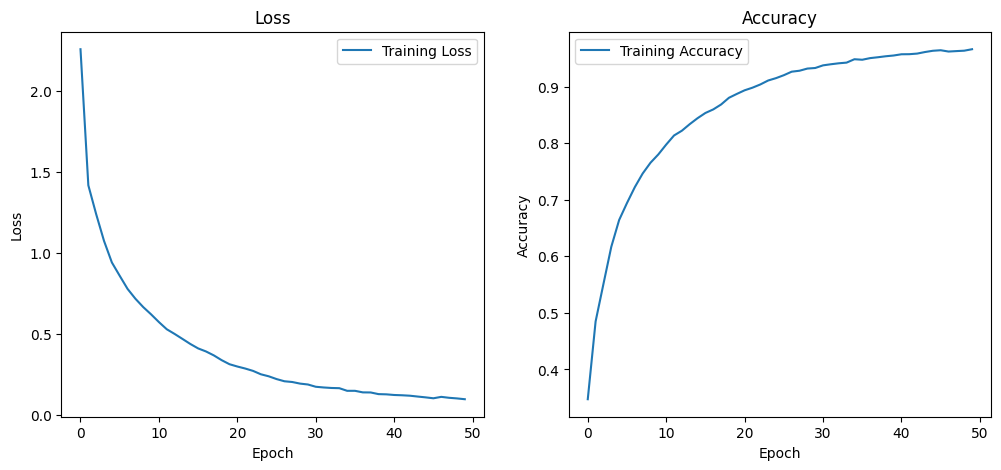

In [19]:
# 绘制损失图
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(network.history['loss'], label='Training Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# 绘制准确率图
plt.subplot(1, 2, 2)
plt.plot(network.history['accuracy'], label='Training Accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()


## **4.6 Prediction sample**

1/1 [==============================] - 2s 2s/step
Original label is Horse and predicted label is Horse


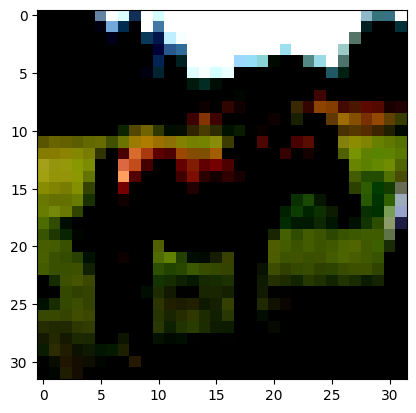

In [20]:
# label mapping

labels = '''Plane Car Bird Cat Deer Dog Frog Horse Ship Truck'''.split()

# select the image from our test dataset
image_number = 9999

plt.imshow(test_imgs[image_number])
n = np.array(test_imgs[image_number])
p = n.reshape(1, 32, 32, 3)
# pass in the network for prediction and
predicted_label = labels[model.predict(p).argmax()]
original_label = labels[test_labels[image_number]]

print("Original label is {} and predicted label is {}".format(
	original_label, predicted_label))


In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models

def residual_block(x, filters, stride=1, downsample=False):
    shortcut = x

    # First convolutional layer
    x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second convolutional layer
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Downsample the shortcut connection if necessary
    if downsample:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Add the shortcut connection
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)

    return x

def build_resnet18(input_shape=(224, 224, 3), num_classes=1000):
    inputs = layers.Input(shape=input_shape)

    # Initial convolution and max-pooling layer
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Residual layers
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, stride=2, downsample=True)
    x = residual_block(x, 128)

    x = residual_block(x, 256, stride=2, downsample=True)
    x = residual_block(x, 256)

    x = residual_block(x, 512, stride=2, downsample=True)
    x = residual_block(x, 512)

    # Global average pooling and output layer
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = models.Model(inputs, outputs)
    return model

# Instantiate and compile the model
resnet18 = build_resnet18(input_shape=(224, 224, 3), num_classes=1000)
resnet18.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
resnet18.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 112, 112, 64)         9408      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_6 (Bat  (None, 112, 112, 64)         256       ['conv2d_6[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 re_lu (ReLU)                (None, 112, 112, 64)         0         ['batch_normalization_6[